In [1]:
!pip install numpy_indexed

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas
import ast
import os
from PIL import Image
import time
import copy
import numpy_indexed as npi

In [ ]:
a = np.asarray([[4, 6, 6],[4, 4, 4]])
b = np.asarray([[6, 6, 6,4],[4, 3, 2, 4]])
count = 0
for i in range(a.shape[0]):
  count += min(npi.in_(a[i, :], b[i, :]).sum(), npi.in_(b[i, :], a[i, :]).sum())
print(count)

5


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# Get parts list - use indices of each part as "label", for one-hot encoding
parts_list = []
with open('/content/drive/My Drive/APS360 Project/share/Data/Input/Datasets/BerendPartsList') as f:
  for line in f:
    word = line[:len(line) - 1] # get rid of '\n
    parts_list.append(int(word))

print(len(parts_list))

85


In [5]:
csv_path = '/content/drive/My Drive/APS360 Project/share/Data/Input/Datasets/Berend/CSV/labels.csv'
image_path = '/content/drive/My Drive/APS360 Project/share/Data/Input/Datasets/Berend/Images'
bbox_label_root = '/content/drive/My Drive/APS360 Project/finalOutput'

In [6]:
class BerendDataset(Dataset):
  # For our dataset, let us accept a CSV file as input
  # + a list of parts, for a one-hot encoding.
  # We will also accept a root directory for images. 
  # We also accept transformations to the image
  def __init__(self, csv_path, parts_list, image_root, transforms, bbox_root):
    self.csv_path = csv_path
    self.parts_list = parts_list
    self.image_root = image_root
    data = pandas.read_csv(csv_path)
    # Convert label col to list of ints of part numbers:
    for i in range(len(data["Labels"])):
      label = data["Labels"][i]
      list_row = ast.literal_eval(label)
      int_list = list(map(int, list_row))
      data["Labels"][i] = list(map(lambda x: parts_list.index(x), int_list))

    # Do same for Color column:
    for i in range(len(data["Color"])):
      label = data["Color"][i]
      list_row = ast.literal_eval(label)
      data["Color"][i] = torch.LongTensor(list(map(int, list_row)))
    
    self.data = data
    self.transforms = transforms
    self.bbox_root = bbox_root
    self.bbox_tracked = {}
    self._BBOX_COL_NAMES = ["Labels", "x_min", "y_min", "x_max", "y_max"]

  def __getitem__(self, idx):
    target = {}
    labels = self.data["Labels"][idx]

    filename = self.data["Name"][idx]
    #print(filename)
    img_path = os.path.join(self.image_root, filename + '.jpg')
    bbox_path = os.path.join(self.bbox_root, filename + '.csv')

    img = Image.open(img_path).convert("RGB")
    if self.transforms is not None:
      img = self.transforms(img)

    target["labels"] = torch.LongTensor(labels)

    if filename in self.bbox_tracked:
      bboxes = self.bbox_tracked[filename]
    else:
      bbox_data = pandas.read_csv(os.path.join(self.bbox_root, filename + '.csv'),
                                  skiprows=2,
                                  header=None,
                                  names=self._BBOX_COL_NAMES)
      bbox_data_np = bbox_data.to_numpy(dtype=np.int_)
      bbox_labels = bbox_data_np[:, 0]
      bbox_targets = bbox_data_np[:, 1:]
      bboxes = torch.zeros([len(labels), 4], dtype=torch.long)
      for i in range(len(bbox_labels)):
        bboxes[i, :] = torch.LongTensor(bbox_targets[i])
      self.bbox_tracked[filename] = bboxes

    target["boxes"] = bboxes
    
    return img, target
  def __len__(self):
        return len(self.data)

In [7]:
data_transform = transforms.Compose([transforms.Resize((375, 500)), transforms.ToTensor()])
dataset = BerendDataset(csv_path=csv_path, parts_list=parts_list, image_root=image_path, transforms=data_transform, bbox_root=bbox_label_root)

In [10]:
my_data = dataset.data
my_data_labels = my_data["Labels"]
label_lengths = {}
for label in my_data_labels:
  length = len(label)
  if (length not in label_lengths):
    label_lengths[length] = 1
  else:
    label_lengths[length] += 1
print(label_lengths)

{1: 152, 2: 135, 3: 116, 4: 95, 5: 87, 6: 72, 7: 57, 8: 42, 9: 33, 10: 27}


In [ ]:
# image, target = dataset[9]
# img = np.transpose(image, [1, 2, 0])
# plt.imshow(img)

In [ ]:
import torchvision

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [ ]:
model.roi_heads.box_predictor.cls_score = nn.Linear(in_features=1024, out_features=len(parts_list), bias=True)
model.roi_heads.box_predictor.bbox_pred = nn.Linear(in_features=1024, out_features=4*len(parts_list), bias=True)

In [ ]:
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [ ]:
model.train()
img, label = dataset[3]
img = img.unsqueeze(0)
label = [label]
print(img.shape)
print(label)



torch.Size([1, 3, 375, 500])
[{'labels': tensor([73, 68]), 'boxes': tensor([[1990,  795, 2297, 1079],
        [1579, 1598, 2992, 2363]])}]


In [ ]:
out = model(img, label)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [ ]:
print(out)

{'loss_classifier': tensor(4.3437, grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(1.2882e-05, grad_fn=<DivBackward0>), 'loss_objectness': tensor(20.2147, grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(244.5419, grad_fn=<DivBackward0>)}


In [ ]:
#train_length = int(0.6*len(dataset))
train_length = 50
#val_length = int(0.2*len(dataset))
val_length = 5
test_length = len(dataset) - train_length - val_length
torch.manual_seed(42)
trainset, valset, testst = torch.utils.data.random_split(dataset,
                                                         [train_length, val_length, test_length])

In [ ]:
def collate_fn(batch):
  images = []
  targets = []
  for lego in batch:
    images.append(lego[0])
    targets.append(lego[1])
  
  return images, targets



In [ ]:
class Batcher:
    def __init__(self, dataset, batch_size=32, drop_last=False):
        self.pics_by_length = {}
        for image, target in dataset:
            # compute the length of the labels:
            llen =target["labels"].shape[0]
            # put the data in the correct key inside self.tweet_by_length
            if llen not in self.pics_by_length:
                self.pics_by_length[llen] = []
            self.pics_by_length[llen].append((image, target),)
         
        #  create a DataLoader for each set of tweets of the same length
        self.loaders = {llen : torch.utils.data.DataLoader(
                                    legos,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=drop_last,   # omit last batch if smaller than batch_size
                                    collate_fn=collate_fn)
            for llen, legos in self.pics_by_length.items()}
        
    def __iter__(self): # called by Python to create an iterator
        # make an iterator for every tweet length
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            # pick an iterator (a length)
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                # no more elements in the iterator, remove it
                iters.remove(im)

In [ ]:
trainloader = Batcher(trainset, batch_size=5, drop_last=True)

In [ ]:
val_loader = Batcher(valset, batch_size=5, drop_last=True)

In [ ]:
def get_precision(model, dataloader):
  model.eval()
  count = 0
  total_predictions = 0
  total_labels = 0
  for inputs, target in dataloader:
    for i in range(len(inputs)):
      inputs[i] = inputs[i].cuda()
      target[i]["labels"] = target[i]["labels"].cuda()
      target[i]["boxes"] = target[i]["boxes"].cuda()
  
    outputs = model(inputs)
    for i in range(len(outputs)):
      label = (target[i]["labels"]).cpu().numpy()
      pred = outputs[i]['labels'].cpu().numpy()
      # Get number of true positives:
      count += min(npi.in_(pred, label).sum(), npi.in_(pred, label).sum())
      # Get total number of predictions:
      total_predictions += len(pred)
      total_labels += len(label)
      print("Labels: {}, Predictions: {}".format(label, pred))
  # Precisions = TP/(TP + FP)
  print(count, total_predictions, total_labels)
  if (total_predictions == 0):
    precision = 0
  else:
    precision = count/total_predictions

  if (total_labels == 0):
    recall = 0
  else:
    recall = count/total_labels
  return (precision, recall)




In [ ]:
def train_model(model, optimizer, trainloader, val_loader, num_epochs=25):
    torch.manual_seed(42)
    since = time.time()

    epochs, train_loss, train_precs, val_precs = [], [], [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        n = 0
        for inputs, target in trainloader:
            for i in range(len(inputs)):
              inputs[i] = inputs[i].cuda()
              target[i]["labels"] = target[i]["labels"].cuda()
              target[i]["boxes"] = target[i]["boxes"].cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs, target)
                class_loss = outputs['loss_classifier']

                class_loss.backward()
                optimizer.step()
                # statistics
                running_loss += class_loss.item()
                n+=1
            if (n % 10 == 0):
              print("Epoch {}, iteration {}".format(epoch, n))
                  
        torch.set_grad_enabled(False)
        epoch_loss = running_loss / n
        train_loss.append(epoch_loss)
        epochs.append(epoch)
        train_prec, train_recall = get_precision(model, trainloader)
        val_prec, val_recall = get_precision(model, val_loader)
        train_precs.append(train_prec)
        val_precs.append(val_prec)

        print('Training - {} Loss: {:.4f} Prec: {:.4f}'.format(epoch, epoch_loss, train_prec))
        print('Validation - {} Prec: {:.4f}'.format(epoch, val_prec))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    """
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    """
    # plotting
    plt.title("Training Loss Curve")
    plt.plot(epochs, train_loss, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Precision Curve")
    plt.plot(epochs, train_precs, label="Train")
    plt.plot(epochs, val_precs, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
    return model

In [ ]:
torch.cuda.empty_cache()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model.parameters(), lr=1e-5)
model = model.cuda()

Epoch 0/19
----------


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Labels: [49  8 71 84  1], Predictions: []
Labels: [16 14 54 80 43], Predictions: [29]
Labels: [44 75 19 73 20], Predictions: []
Labels: [49  8 71 84  1], Predictions: [29]
Labels: [71 18 30 49 39], Predictions: [16]
Labels: [65 11  6 34 36], Predictions: []
Labels: [54 27 55 10 73], Predictions: []
Labels: [45 77 66 34 56], Predictions: [29 29 29]
Labels: [59 44  7 10 82], Predictions: []
Labels: [32  0 30 13 26], Predictions: []
Labels: [38], Predictions: []
Labels: [70], Predictions: []
Labels: [33], Predictions: []
Labels: [32], Predictions: []
Labels: [65], Predictions: []
Labels: [32  0 30 13 26 80], Predictions: []
Labels: [49  8 71 84  1 29], Predictions: [29 29]
Labels: [40 17 61 12  1 28], Predictions: []
Labels: [45 77 66 34 56 24], Predictions: []
Labels: [32 19 80 27 21 75], Predictions: [16 41]
Labels: [70 51], Predictions: []
Labels: [35 74], Predictions: []
Labels: [72 12], Predictions: []
Labels: [26 56], Predictions: []
Labels: [22  3], Predictions: []
2 10 95
0 0 0
Tr

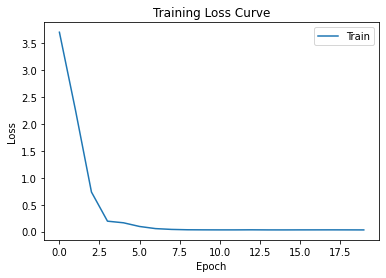

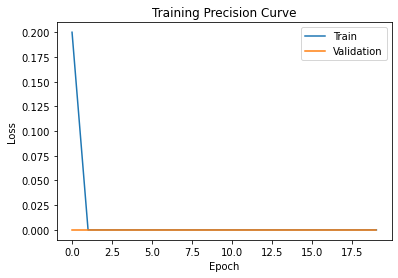

In [ ]:
model_ft = train_model(model, optimizer_ft, trainloader, val_loader, num_epochs=20)

In [ ]:
class FastRCNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FastRCNN, self).__init__()
        self.fc1 = nn.Linear(4096, num_classes*4)
        self.fc2 = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))


In [ ]:
# for each pixel on the feature map, need to generate 9 anchor boxes
# feed in the center point of the feature
# output the x1, y1, x2, y2 coordinates for each box

class RPN(nn.Module):
    def __init__(self, ratio=[0.5, 1, 2], anchor_size=[8, 16, 32]):
        Super(RPN, self).__init__()
        self.ratio = ratio
        self.anchor_size = anchor_size
        self.num_anchors = len(ratio)*len(anchor_size)
